In [643]:
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.5f}'.format
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

In [509]:
#! kaggle competitions download -c ieee-fraud-detection
#! unzip ieee-fraud-detection.zip

In [596]:
limit = None
train = pd.read_csv("train_transaction.csv", nrows=limit)
test = pd.read_csv("test_transaction.csv", nrows=limit)

In [597]:
train["isFraud"].mean()

0.03499000914417313

In [598]:
len(train)

590540

In [599]:
def categorify(df, cat_vars):
    categories = {}
    for cat in cat_vars:
        df[cat] = df[cat].astype("category").cat.as_ordered()
        categories[cat] = df[cat].cat.categories
    return categories


def apply_test(test,categories):
    for cat, index in categories.items():
        test[cat] = pd.Categorical(test[cat],categories=categories[cat],ordered=True)


def plot_accuracy(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(12, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
    
def print_results(grid_result):
    para = pd.DataFrame.from_dict(grid_result.cv_results_['params'])
    mean = pd.DataFrame(grid_result.cv_results_['mean_test_score'],columns=['mean_test_score'])
    stds = pd.DataFrame(grid_result.cv_results_['std_test_score'],columns=['std_test_score'])
    time = pd.DataFrame(grid_result.cv_results_['mean_fit_time'],columns=['mean_fit_time'])

    df = para.join(mean.join(stds)).join(time).sort_values('mean_test_score', ascending=False)
    df.reset_index().drop(columns=['index'])
    return df

# Preprocessing

In [600]:
# Create time of day variable
train["Time of Day"] = np.floor(train["TransactionDT"]/3600/183)
test["Time of Day"] = np.floor(test["TransactionDT"]/3600/183)

# Drop columns
train.drop("TransactionDT",axis=1,inplace=True)
test.drop("TransactionDT",axis=1,inplace=True)

# Select continuous and categorical variables
cont_vars = ["TransactionAmt"]
cat_vars = ["ProductCD","addr1","addr2","P_emaildomain","R_emaildomain","Time of Day"] + [col for col in train.columns if "card" in col]

# set training and testing set
x_train = train[cont_vars + cat_vars].copy()
y_train = train["isFraud"].copy()
x_test = train[cont_vars + cat_vars].copy()
y_test = train["isFraud"].copy()


# Scale Values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train["TransactionAmt"] = scaler.fit_transform(x_train["TransactionAmt"].values.reshape(-1,1))
x_test["TransactionAmt"] = scaler.transform(x_test["TransactionAmt"].values.reshape(-1,1))

# Reduce Cardinality in Categorical
idx_list = x_train["card1"].value_counts()[x_train["card1"].value_counts()<=100].index.tolist()
x_train.loc[x_train["card1"].isin(idx_list),"card1"] = "Others"
x_test.loc[x_test["card1"].isin(idx_list),"card1"] = "Others"

# Fill NAs
x_train[cat_vars] = x_train[cat_vars].fillna("Missing")
x_test[cat_vars] = x_test[cat_vars].fillna("Missing")

In [601]:
cat_vars

['ProductCD',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'Time of Day',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6']

In [602]:
print(train[cat_vars].info())
print(train[cat_vars].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ProductCD      590540 non-null  object 
 1   addr1          524834 non-null  float64
 2   addr2          524834 non-null  float64
 3   P_emaildomain  496084 non-null  object 
 4   R_emaildomain  137291 non-null  object 
 5   Time of Day    590540 non-null  float64
 6   card1          590540 non-null  int64  
 7   card2          581607 non-null  float64
 8   card3          588975 non-null  float64
 9   card4          588963 non-null  object 
 10  card5          586281 non-null  float64
 11  card6          588969 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 54.1+ MB
None
          addr1     addr2  Time of Day     card1     card2     card3     card5
count 524834.00 524834.00    590540.00 590540.00 581607.00 588975.00 586281.00
mean     290.73     86.80        

In [603]:
# convert to integers
categories = categorify(x_train,cat_vars)
apply_test(x_test,categories)
for cat in cat_vars:
    x_train[cat] = x_train[cat].cat.codes+1
    x_test[cat] = x_test[cat].cat.codes+1

In [604]:
print(x_train[cat_vars].describe())

       ProductCD     addr1     addr2  P_emaildomain  R_emaildomain  \
count  590540.00 590540.00 590540.00      590540.00      590540.00   
mean        4.22    166.49     64.19          21.18           5.63   
std         1.42     93.70      4.33          18.12          10.91   
min         1.00      1.00      1.00           1.00           1.00   
25%         4.00     80.00     63.00           4.00           1.00   
50%         5.00    152.00     63.00          18.00           1.00   
75%         5.00    251.00     63.00          21.00           1.00   
max         5.00    333.00     75.00          60.00          61.00   

       Time of Day     card1     card2     card3     card4     card5     card6  
count    590540.00 590540.00 590540.00 590540.00 590540.00 590540.00 590540.00  
mean         11.69    444.82    266.18     46.01      4.60     86.47      3.74  
std           7.01    228.74    159.24     10.63      0.62     35.10      0.46  
min           1.00      1.00      1.00      1

In [605]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [606]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_sm, y_train = sm.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_sm,columns=x_train.columns)

In [607]:
print(x_train.describe())
x_train.columns

       TransactionAmt  ProductCD      addr1      addr2  P_emaildomain  \
count      1139754.00 1139754.00 1139754.00 1139754.00     1139754.00   
mean             0.02       3.64     191.09      65.63          20.44   
std              0.94       1.74     104.47       5.77          16.47   
min             -0.56       1.00       1.00       1.00           1.00   
25%             -0.40       2.00      99.00      63.00          11.00   
50%             -0.25       5.00     174.00      63.00          18.00   
75%              0.06       5.00     312.00      63.00          21.00   
max            132.97       5.00     333.00      75.00          60.00   

       R_emaildomain  Time of Day      card1      card2      card3      card4  \
count     1139754.00   1139754.00 1139754.00 1139754.00 1139754.00 1139754.00   
mean            8.41        11.81     429.59     268.23      49.87       4.59   
std            11.73         6.72     227.37     160.35      13.83       0.62   
min             1.

Index(['TransactionAmt', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain',
       'R_emaildomain', 'Time of Day', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6'],
      dtype='object')

In [622]:
y_train.value_counts()

1    569877
0    569877
Name: isFraud, dtype: int64

In [623]:
len(x_train)

1139754

In [609]:
x_train.values
y_train.values

array([0, 0, 0, ..., 1, 1, 1])

# Boosted Trees

In [644]:
X, y = x_train.values, y_train.values
data_dmatrix = xgb.DMatrix(data=X,label=y)#, feature_names=x_train.columns)

model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# grid search parameters
colsample_bytree = [0.6, 0.8, 1.0]
learning_rate= [0.1, 0.01, 0.001]
max_depth= [3, 4, 5]
alpha= [1,2,5,10]
n_estimators = [5,10,15,20]

params = dict(
    colsample_bytree = colsample_bytree,
    learning_rate= learning_rate,
    max_depth= max_depth,
    alpha= alpha,
    n_estimators=n_estimators
)

grid_result = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=4, cv=3, verbose = True).fit(x_train.values, y_train.values)
print_results(grid_result).head(20)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 17.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 32.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 54.3min
[Parallel(n_jobs=4)]: Done 1296 out of 1296 | elapsed: 58.2min finished


,alpha,colsample_bytree,learning_rate,max_depth,n_estimators,mean_test_score,std_test_score,mean_fit_time
33,1,0.60000,0.00100,5,10,0.56318,0.02056,7.18845
141,2,0.60000,0.00100,5,10,0.56314,0.02057,9.44213
249,5,0.60000,0.00100,5,10,0.56303,0.02055,7.35203
357,10,0.60000,0.00100,5,10,0.56288,0.02050,10.06315
129,2,0.60000,0.01000,5,10,0.56053,0.02071,7.19410
21,1,0.60000,0.01000,5,10,0.56051,0.02071,7.95814
237,5,0.60000,0.01000,5,10,0.56015,0.02036,7.57807
345,10,0.60000,0.01000,5,10,0.56004,0.02029,10.18280
35,1,0.60000,0.00100,5,20,0.55827,0.02109,13.83122
359,10,0.60000,0.00100,5,20,0.55827,0.02102,19.36098


In [645]:
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.60, learning_rate = 0.001,
                max_depth = 5, alpha = 1, n_estimators = 20)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
roc = sklearn.metrics.roc_auc_score(y_test,y_pred)
roc

0.7097804607795707

In [651]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.6,'learning_rate': 0.01,
                'max_depth': 5, 'alpha': 1, 'n_estimators':20,}

model = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[22:28:29] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




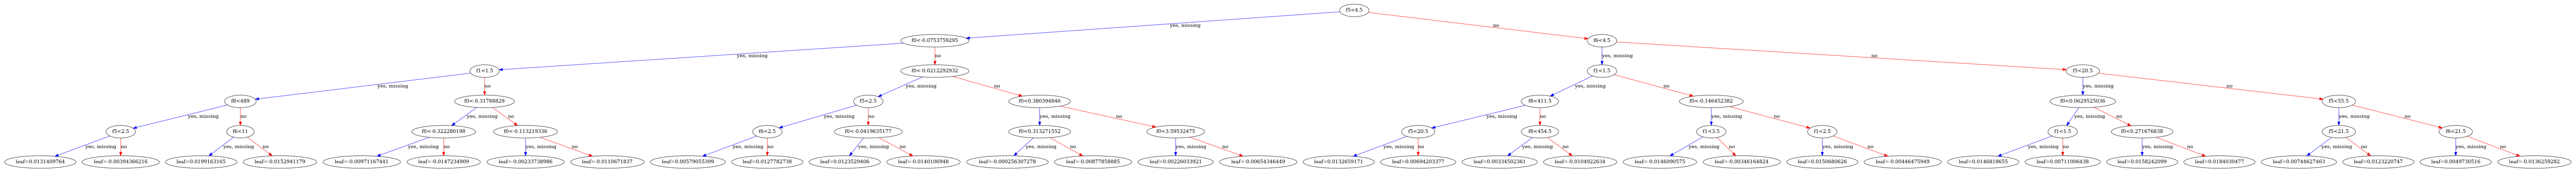

In [650]:
import matplotlib.pyplot as plt
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

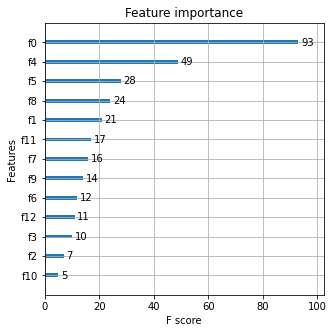

In [648]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Dense Network

In [632]:
def create_model(units=10, num_layers=2, learning_rate=0.01):
    layers=[]
    for i in range(num_layers):
        if i == 0 :
            layers += [
                tf.keras.layers.Dense(units, activation='relu', input_shape=(13,))
            ]
        else:
            layers += [
                tf.keras.layers.Dense(units, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2)
            ]
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])
    
    return model

In [665]:
model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [32]
num_layers = [1,2,3,4,5]
learning_rate = [0.01]
epochs = [10]
batches = [64]

param_grid = dict(
    units=units,
    num_layers=num_layers,
    learning_rate=learning_rate,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(x_train, y_train)
print_results(grid_result)

5937/5937 [==============================] - 4s 728us/step - loss: 15.4245 - accuracy: 0.0000e+00


KeyboardInterrupt: 

Model: "sequential_892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2516 (Dense)           (None, 32)                448       
_________________________________________________________________
dense_2517 (Dense)           (None, 32)                1056      
_________________________________________________________________
batch_normalization_1047 (Ba (None, 32)                128       
_________________________________________________________________
dropout_935 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_2518 (Dense)           (None, 32)                1056      
_________________________________________________________________
batch_normalization_1048 (Ba (None, 32)                128       
_________________________________________________________________
dropout_936 (Dropout)        (None, 32)             

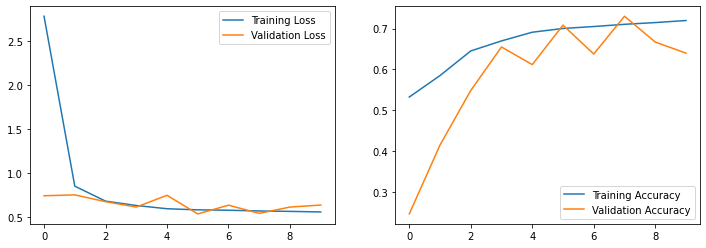

In [638]:
model = create_model(units=32, num_layers=5, learning_rate=0.001)
model.summary()
history = model.fit(x_train.values, y_train.values, epochs=10, validation_split=.05, batch_size=100)
plot_accuracy(history)

In [641]:
y_pred = model.predict(x_test)
roc = sklearn.metrics.roc_auc_score(y_test,y_pred)
roc

0.7881282147661266

# AUTOENCODER

In [659]:
#Change mean and scale of the noise according to your data
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
len_input_output = x_train.shape[-1]
def make_dae():
    dae = Sequential([
        Dense(units=len_input_output*2, 
              activation="relu", input_shape=(len_input_output,)),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output*2, activation="relu"),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output*2, activation="relu"),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output, activation="linear"),
    ])
    dae.compile(
        optimizer='adam', 
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return dae
dae = make_dae()
history = dae.fit(
    x_train_noisy,
    x_train,
    batch_size = 100,
    epochs = 10,
    validation_split=.2
    )

Epoch 1/10
9119/9119 [==============================] - 32s 4ms/step - loss: 6378.0479 - accuracy: 0.7898 - val_loss: 8122.8066 - val_accuracy: 0.8607
Epoch 2/10
9119/9119 [==============================] - 13s 1ms/step - loss: 4380.6230 - accuracy: 0.8198 - val_loss: 3977.9495 - val_accuracy: 0.8681
Epoch 3/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3922.4653 - accuracy: 0.8290 - val_loss: 3693.0752 - val_accuracy: 0.8557
Epoch 4/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3769.8394 - accuracy: 0.8315 - val_loss: 3234.5149 - val_accuracy: 0.8780
Epoch 5/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3614.7390 - accuracy: 0.8348 - val_loss: 2999.2710 - val_accuracy: 0.8813
Epoch 6/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3459.5784 - accuracy: 0.8306 - val_loss: 2769.8567 - val_accuracy: 0.8619
Epoch 7/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3334.7458 - accur

In [660]:
x_train_denoised = dae.predict(x_train)
x_train_denoised

array([[-5.39384782e-02,  4.11921740e+00,  1.77533600e+02, ...,
         4.67901850e+00,  8.35909958e+01,  3.78697467e+00],
       [-8.37025791e-02,  3.67144966e+00,  1.69735687e+02, ...,
         4.62793398e+00,  8.30528488e+01,  3.61490226e+00],
       [-8.91969651e-02,  3.61557555e+00,  1.79066223e+02, ...,
         4.63158560e+00,  8.36959763e+01,  3.62728310e+00],
       ...,
       [-2.06026077e-01,  3.75377703e+00,  1.99357239e+02, ...,
         4.49442768e+00,  7.75231705e+01,  3.84545135e+00],
       [-1.83763504e-02,  3.89035296e+00,  1.31727875e+02, ...,
         4.63215256e+00,  7.29893265e+01,  3.77926421e+00],
       [-1.06598035e-01,  3.70220637e+00,  2.06080780e+02, ...,
         4.63989258e+00,  8.83461151e+01,  3.66837311e+00]], dtype=float32)

Model: "sequential_894"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2529 (Dense)           (None, 32)                448       
_________________________________________________________________
dense_2530 (Dense)           (None, 32)                1056      
_________________________________________________________________
batch_normalization_1064 (Ba (None, 32)                128       
_________________________________________________________________
dropout_943 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_2531 (Dense)           (None, 32)                1056      
_________________________________________________________________
batch_normalization_1065 (Ba (None, 32)                128       
_________________________________________________________________
dropout_944 (Dropout)        (None, 32)             

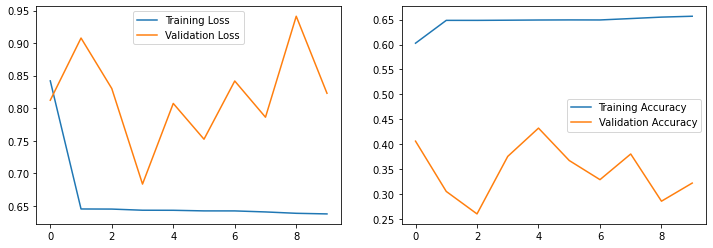

In [663]:
def create_model(units=10, num_layers=2, learning_rate=0.01):
    layers=[]
    for i in range(num_layers):
        if i == 0 :
            layers += [
                tf.keras.layers.Dense(units, activation='relu', input_shape=(13,))
            ]
        else:
            layers += [
                tf.keras.layers.Dense(units, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2)
            ]
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])
    
    return model

#model = KerasClassifier(build_fn=create_model)

model = create_model(units=32, num_layers=5, learning_rate=0.01)
model.summary()
history = model.fit(x_train_denoised, y_train.values, epochs=10, validation_split=.15, batch_size=100)
plot_accuracy(history)

In [664]:
y_pred = model.predict(x_test)
roc = sklearn.metrics.roc_auc_score(y_test,y_pred)
roc

0.6041031203907591

# Embedding

In [652]:
# process x_train input to fit model
input_list = []
for i in cat_vars:
    input_list.append(x_train[i].values)
    input_list.append(x_train[cont_vars].values)

# modify x_test input to fit model
test_list = []
for i in cat_vars:
    test_list.append(x_test[i].values)
    test_list.append(x_test[cont_vars].values)

In [653]:
# get embedding size for each categorical variable
def get_emb_sz(cat_col,categories_dict):
    num_classes = len(categories_dict[cat_col])
    return int(min(600,round(1.6*num_classes**0.56)))

In [654]:
# define the neural networks
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras import Model
def combined_network(cat_vars,categories_dict,cont_vars, layers):
    inputs = []
    embeddings = []
    emb_dict = {}
    # create embedding layer for each categorical variables
    for i in range(len(cat_vars)):
        emb_dict[cat_vars[i]] = Input(shape=(1,))
        emb_sz = get_emb_sz(cat_vars[i],categories_dict)
        vocab = len(categories_dict[cat_vars[i]]) +1
        embedding = Embedding(vocab,emb_sz,input_length=1)(emb_dict[cat_vars[i]])
        embedding = Reshape(target_shape=(emb_sz,))(embedding)
        inputs.append(emb_dict[cat_vars[i]])
        embeddings.append(embedding)
        # concat continuous variables with embedded variables
        cont_input = Input(shape=(len(cont_vars),))
        embedding = BatchNormalization()(cont_input)
        inputs.append(cont_input)
        embeddings.append(embedding)
        x = Concatenate()(embeddings)
    # add user-defined fully-connected layers separated with batchnorm and dropout layers
    for i in range(len(layers)):
        if i == 0:
            x = Dense(layers[i],activation="relu")(x)
        else:
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            x = Dense(layers[i],activation="relu")(x)
            output = Dense(1,activation="sigmoid")(x)
            model = Model(inputs,output)
    return model

In [655]:
layers = [200,100]

model = combined_network(cat_vars[:],categories,cont_vars[:], layers)
opt = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=["accuracy"])

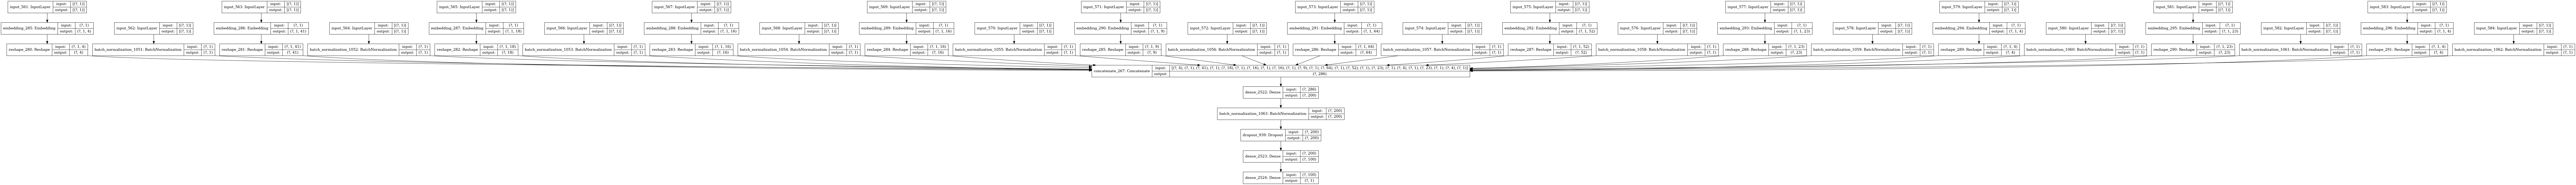

In [656]:
keras.utils.plot_model(model, "embedding_model.png", show_shapes=True) 

Epoch 1/10
28494/28494 [==============================] - 108s 4ms/step - loss: 0.3868 - accuracy: 0.8261 - val_loss: 0.4052 - val_accuracy: 0.8216
Epoch 2/10
28494/28494 [==============================] - 107s 4ms/step - loss: 0.3120 - accuracy: 0.8658 - val_loss: 0.3126 - val_accuracy: 0.8727
Epoch 3/10
28494/28494 [==============================] - 115s 4ms/step - loss: 0.2861 - accuracy: 0.8780 - val_loss: 0.2856 - val_accuracy: 0.8849
Epoch 4/10
28494/28494 [==============================] - 114s 4ms/step - loss: 0.2699 - accuracy: 0.8856 - val_loss: 0.2687 - val_accuracy: 0.8962
Epoch 5/10
28494/28494 [==============================] - 119s 4ms/step - loss: 0.2587 - accuracy: 0.8910 - val_loss: 0.2684 - val_accuracy: 0.8963
Epoch 6/10
28494/28494 [==============================] - 113s 4ms/step - loss: 0.2510 - accuracy: 0.8942 - val_loss: 0.2518 - val_accuracy: 0.9058
Epoch 7/10
28494/28494 [==============================] - 117s 4ms/step - loss: 0.2443 - accuracy: 0.8974 - val_

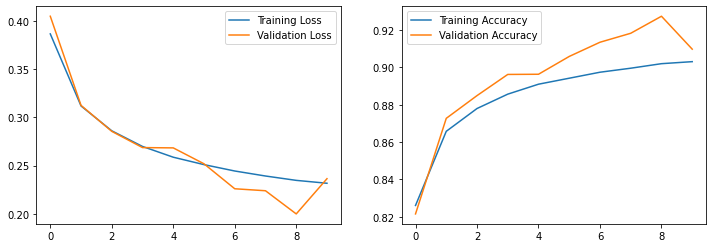

In [657]:
history = model.fit(input_list,y_train,epochs=10, validation_split = 0.2)
plot_accuracy(history)

In [658]:
y_pred = model.predict(test_list)
roc = sklearn.metrics.roc_auc_score(y_test,y_pred)
roc

0.9413623085024263